### Score Based SDE (continous-time) denoising

Consider a 1D noisy signal  
$$
y \in \mathbb{R}^n,\quad \mu = 0,\quad \mathrm{Cov}(y)=\Sigma.
$$  
We infer noise parameters  
$$
\mu = 0,\quad \Sigma
$$  
using Gibbs Sampling (+ HMC).

**Natural Images**  
$$
\Sigma_\sigma = \Sigma(\sigma,\psi)
$$  
where, sigma^2 = noise amplitude and psi = spectral indeex

**CMB**  
Model temperature fluctuations as  
$$
\mu = 0,\quad \mathrm{Cov}(y) = \Sigma_\phi,
$$  

where  
$$
\Sigma_\phi = \Sigma(H_0,\;\Omega_b,\;\sigma).
$$  

In both cases, we consider a covariance matrix that is diagonal in Fourier space. We write  
$$
\Sigma_\phi = \sigma^2 \cdot \mathbf{F}^\top \mathbf{D}_\psi \mathbf{F},
$$  
where F is the orthonormal discrete DFT matrix, sigma > 0 controls the noise amplitude, and D_psi is a diagonal matrix parameterized by the power spectrum function S_psi(k):  
$$
\mathbf{D}_\psi = \mathrm{diag}(S_\psi(k)).
$$  
$$
\text{Let } \varepsilon \text{ denote the predicted noise and } \hat{\varepsilon}_k = (\mathbf{F} \varepsilon)_k \text{ be its Fourier coefficients.}
$$
The log-posterior  (for HMC sampling) is given by
$$
\log p(\phi \mid \varepsilon = y - x) = \log p(\varepsilon \mid \phi) + \log p(\phi) + C
$$
Then the analytically tractable negative log-likelihood is given by:  
$$
- \log p(\varepsilon \mid \phi) = \frac{1}{2} \sum_k \left[ \log\left(\sigma^2 S_\psi(k)\right) + \frac{|\hat{\varepsilon}_k|^2}{\sigma^2 S_\psi(k)} \right] + C,
$$  
where \( C \) is an arbitrary constant.


#### The WorkFlow

1D execution -> 1D Gibbs-Sampling -> 2D Execution (alter 1D acc.) -> 2D Gibbs Sampling (alter 1D acc.) -> CMB inferencing

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd
import random
import torch
from torch.utils.data import DataLoader, TensorDataset
import math
import warnings
import importlib
warnings.filterwarnings('ignore')

In [3]:
import importlib
import modules
import modules.comp.nn_based
importlib.reload(modules.comp.nn_based)
from modules.comp.nn_based import *
from sklearn.model_selection import train_test_split

In [4]:
batch_size = 32
num_epochs = 20
train_split = 0.8

#### Data-Creation 1D (Synthetic)

In [161]:
import modules.utils.noise_create
importlib.reload(modules.utils.noise_create)
from modules.utils.noise_create import create_1d_data, create_1d_data_colored

In [6]:
def plot_results(noisy, clean, denoised, title=""):
    """
    Plot a few examples comparing the noisy input, clean signal, and denoised output.
    """
    num_examples = 3
    plt.figure(figsize=(8, 4))
    for i in range(num_examples):
        plt.subplot(num_examples, 1, i+1)
        plt.plot(clean[i].squeeze().cpu().numpy(), label="Clean Signal", linewidth=2)
        plt.plot(noisy[i].squeeze().cpu().numpy(), label="Noisy Signal", alpha=0.5)
        plt.plot(denoised[i].squeeze().cpu().detach().numpy(), label="Denoised Output", linestyle="--")
        plt.legend(loc="upper right")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

1D Flat PSD (white Noise) - Sine Signal

(10000, 100) (10000, 100) (10000, 100)


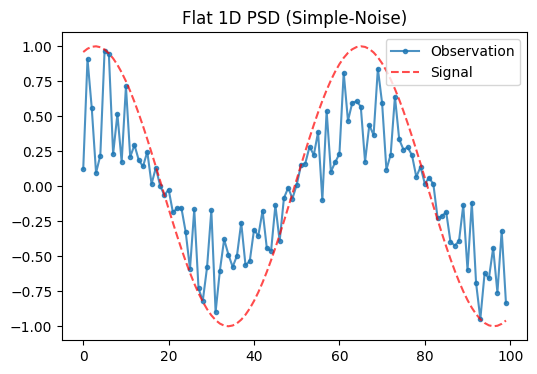

In [ ]:
n_samples = 10000 ## num of samples
n_depth = 100 ## sequence-length
rn = random.randint(0, n_samples)

observation, signal, noise = create_1d_data(n_samples=n_samples, n_depth=n_depth, phi = 1.0)
print(observation.shape, signal.shape, noise.shape)

plt.figure(figsize=(6, 4))

plt.plot(observation[rn], label="Observation", alpha=0.8, marker='.')
plt.plot(signal[rn], label="Signal", linestyle="dashed", alpha=0.7, color = 'red')
plt.title('Flat 1D PSD (Simple-Noise)')
plt.legend()
plt.show()

(10000, 100)
(10000, 100) (10000, 100) (10000, 100)


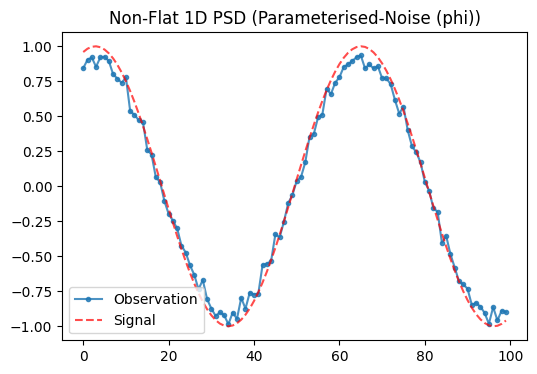

In [120]:
observation, signal, noise = create_1d_data_colored(n_samples=n_samples, n_depth=n_depth, phi=1.0, decay=0.1, sigma=0.4)
print(observation.shape, signal.shape, noise.shape)

plt.figure(figsize=(6, 4))

plt.plot(observation[rn], label="Observation", alpha=0.8, marker='.')
plt.plot(signal[rn], label="Signal", linestyle="dashed", alpha=0.7, color = 'red')
plt.title('Non-Flat 1D PSD (Parameterised-Noise (phi))')
plt.legend()
plt.show()

In [64]:
observation_train, observation_val, signal_train, signal_val = train_test_split(observation, signal, test_size = 1 - train_split, random_state=28)

print('Shape: ', observation_train.shape, signal_train.shape, observation_val.shape, signal_val.shape)

observation_train = torch.tensor(observation_train, dtype=torch.float32)
signal_train = torch.tensor(signal_train, dtype=torch.float32)
observation_val = torch.tensor(observation_val, dtype=torch.float32)
signal_val = torch.tensor(signal_val, dtype=torch.float32)

dataset_train = TensorDataset(observation_train, signal_train)
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

dataset_val = TensorDataset(observation_val, signal_val)
val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

print(train_loader, val_loader)

Shape:  (8000, 100) (8000, 100) (2000, 100) (2000, 100)
<torch.utils.data.dataloader.DataLoader object at 0x000002B9E7B0D4C0> <torch.utils.data.dataloader.DataLoader object at 0x000002B9DEB6E5D0>


1D Non-Flat PSD - Colored Noise - Sine Signal

In [316]:
from modules.comp import unet
from modules.comp import diffusion_1d
from modules.comp import diff_trainer
import modules.utils.noise_create

importlib.reload(modules.comp.unet)
importlib.reload(modules.comp.diffusion_1d)
importlib.reload(modules.comp.diff_trainer)
importlib.reload(modules.utils.noise_create)

from modules.comp import unet
from modules.comp import diffusion_1d
from modules.comp import diff_trainer
from modules.utils.noise_create import create_1d_data, create_1d_data_colored

In [325]:
gmodel = unet.Unet1DGDiff(
    dim = 2, ## ? Something is wrong here?
    channels=1, 
)

## time-embedding shape -> t = torch.randint(0, self.num_timesteps, (b,), device=device).long() --> (b, )
t_shape = (2, )
x_shape = (2, 1, 100)

print(x_shape, t_shape)

print('- UNET-summary -')
gmodel.summary(x_shape=x_shape, t_shape=t_shape)

### Just the diffusion framework
gdiffusion = diffusion_1d.GibbsDiff1D(
    gmodel,
    seq_length = 100,
    num_timesteps = 1000,
)

Dimension-Cluster:  2 4 8 16 32
(2, 1, 100) (2,)
- UNET-summary -
Careful, no alpha was given, set to 0
____________________________________________________________________________________________________
Model: Unet1D
Layer (type)                            Output Shape             Param #        
input_1 (InputLayer)                    (2, 1, 100)              0              
input_2 (InputLayer)                    (2,)                     0              
init_conv.proj (Conv1d)                 (2, 2, 100)              8              
init_conv.norm (LayerNorm)              (2, 100, 2)              4              
init_conv.act (SiLU)                    (2, 2, 100)              0              
down_blocks.0.block1.proj (Conv1d)      (2, 4, 100)              28             
down_blocks.0.block1.norm (LayerNorm)   (2, 100, 4)              8              
down_blocks.0.block1.act (SiLU)         (2, 4, 100)              0              
down_blocks.0.block1 (BlockGDiff)       (2, 4, 100) 

In [326]:
print(signal_train.shape, signal_val[:50].shape)

torch.Size([8000, 100]) torch.Size([50, 100])


In [327]:
train_num_steps = 10000

In [328]:
gtrainer = diff_trainer.Trainer1DGDiff(
    gdiffusion,
    signal_train,
    signal_val[:50],
    train_batch_size = 8,
    train_lr = 1e-5,
    train_num_steps = train_num_steps, # total training steps
    gradient_accumulate_every = 2,     # gradient accumulation steps
    ema_decay = 0.995,                 # exponential moving average decay
)

train_loss_curve, val_loss_curve = gtrainer.train()

Optimization Steps:   0%|          | 0/10000 [00:00<?, ?it/s]

Optimization Steps: 100%|██████████| 10000/10000 [2:34:30<00:00,  1.08it/s]      

Training complete.


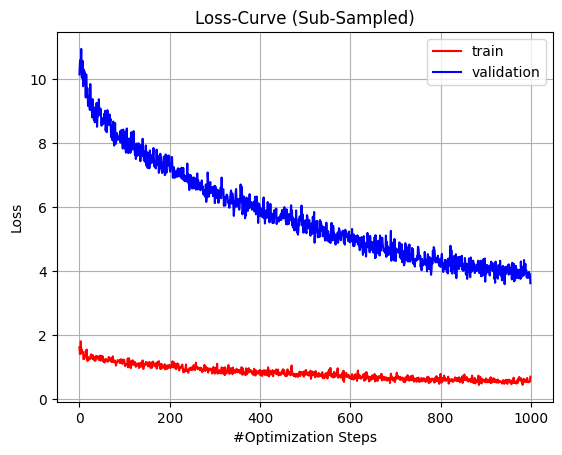

In [329]:
fig = plt.Figure(figsize=(7, 7))

rate = 10
plt.plot(np.arange(train_num_steps // rate), train_loss_curve[::rate], color = 'red', label = 'train')
plt.plot(np.arange(train_num_steps // rate), val_loss_curve[::rate], color = 'blue', label = 'validation')

plt.ylabel('Loss')
plt.xlabel('#Optimization Steps')
plt.title('Loss-Curve (Sub-Sampled)')

plt.grid()
plt.legend()
plt.show()

Non-Blind denoising

In [345]:
yt = observation_val[0].view(1, 1, -1)
print(yt.shape)

phi = 1.0
sigma = 0.4

sigma_timestep = gdiffusion.get_closest_timestep(torch.tensor([sigma]).to(device)).item()
print('closest_discrete_timestep: ', sigma_timestep)

sigma_timestep = torch.tensor(sigma_timestep).unsqueeze(0).repeat(yt.shape[0])
print(sigma_timestep)

x_denoised = gdiffusion.denoise_samples_batch_time(yt, sigma_timestep, phi_ps=phi).cpu().numpy()
print(x_denoised.shape)

torch.Size([1, 1, 100])
closest_discrete_timestep:  117
tensor([117])
(1, 1, 100)


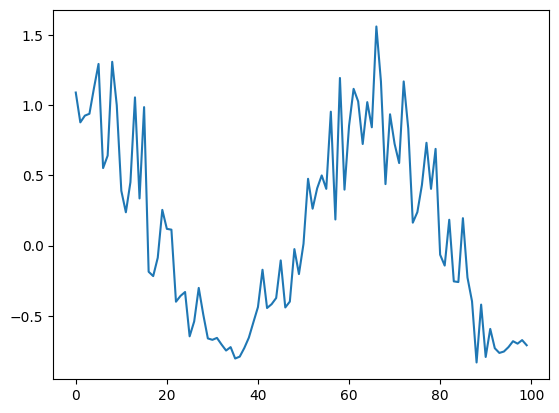

In [346]:
plt.plot(x_denoised[0][0])
plt.show()

Noising -> Denosing (non-blind)

In [ ]:
sigmas = [0.2] ## noise-amplitude
phis = [-1, 0, 1]

sigmas = [model_gdiff.get_closest_timestep(torch.tensor([s]).to(device), ret_sigma=True)[1].item() for s in sigmas]

In [ ]:
x = signal[0]
print(x.shape)

for sigma_idx, sigma in enumerate(sigmas):
    for phi_idx, phi in enumerate(phis):
        
        print('Sigma: ', sigma)
        print('Phi: ', phi)

        # Make test data and auxilary variables
        sigma_timestep = model_gdiff.get_closest_timestep(torch.tensor([sigma]).to(device)).item()
        alpha_bar_t = model_gdiff.alpha_bar_t[sigma_timestep].reshape(-1, 1, 1, 1).to(device)
        eps, psd =  get_colored_noise_2d(x.shape, phi, ret_psd=True)
        eps = torch.sqrt(1 - alpha_bar_t)/torch.sqrt(alpha_bar_t) * eps.to(device)
        y = x + eps # Noisy image
        psd = (torch.sqrt(1 - alpha_bar_t)/torch.sqrt(alpha_bar_t))**2 * psd.to(device) * x.shape[-1] * x.shape[-2]
        yt = torch.sqrt(alpha_bar_t) * y # Noisy image normalized for the diffusion model

        ## x_0_hat
        x_denoised = gdiffusion.denoise_samples_batch_time(yt, torch.tensor(sigma_timestep).unsqueeze(0).repeat(yt.shape[0]), phi_ps=phi)
        print(x_denoised.shape)

        ## E[x|y]
        repeat = 20
        x_denoised_mean = gdiffusion.denoise_samples_batch_time(yt.repeat(repeat, 1, 1, 1), torch.tensor(sigma_timestep).unsqueeze(0).repeat(yt.shape[0]*repeat), phi_ps=phi)
        x_denoised_mean = x_denoised_mean.reshape(repeat, yt.shape[0], 1, yt.shape[2], yt.shape[3]).mean(dim=0)
        print(x_denoised_mean.shape)

Blind-Denoising